In [1]:
import findspark
findspark.init()

from pyspark.sql import SparkSession
from pyspark.sql.functions import format_number, mean, min, max, corr, stddev
from pyspark.sql.functions import (dayofmonth, hour, dayofyear, month, year, weekofyear, format_number, date_format, asc, desc)
from pyspark.sql.functions import explode, col, element_at, size, split
from pyspark.sql.functions import udf

In [2]:
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.feature import VectorAssembler

from pyspark.ml.clustering import KMeans, BisectingKMeans


In [3]:
# Build a SparkSession named as "test123"
spark = SparkSession.builder \
    .appName('test_123') \
    .master('local[*]') \
    .config('spark.sql.execution.arrow.pyspark.enabled', True) \
    .config('spark.sql.session.timeZone', 'UTC') \
    .config('spark.driver.memory','8g') \
    .config('spark.ui.showConsoleProgress', True) \
    .config('spark.sql.repl.eagerEval.enabled', True) \
    .getOrCreate()

## Loading the Data

In [4]:
paps = spark.read.json("../data/processed/dummy.json/")

In [5]:
#Adding an ID to each paper so the abstract data analysis can be attributed to a paper
from pyspark.sql.functions import monotonically_increasing_id
papersWIDs = paps.withColumn("id", monotonically_increasing_id())
# remving nans
print(papersWIDs.count())
papersWIDs_woNA = papersWIDs.dropna()
print(papersWIDs_woNA.count())
papersWIDs_woNA_woNone = papersWIDs_woNA.filter("None == 0")
print(papersWIDs_woNA_woNone.count())

3000
2931
1852


## Clustering

In [8]:
cols = [c for c in papersWIDs_woNA_woNone.columns if not c in ["title", "id"]]
cols

['CERN_LHC_Coll',
 'GeV',
 'None',
 'anomaly',
 'background',
 'citation_count',
 'dark_matter',
 'dark_matter__mass',
 'effective_field_theory',
 'heavy_ion__scattering',
 'higher-order__1',
 'kinematics',
 'lattice',
 'lattice_field_theory',
 'new_physics',
 'num_refs',
 'number_of_pages',
 'numerical_calculations',
 'p_p__scattering',
 'quantum_chromodynamics',
 'quark',
 'sensitivity',
 'stability',
 'structure']

In [9]:
from pyspark.ml.feature import MinMaxScaler, StandardScaler

In [10]:
assembler = VectorAssembler().setInputCols(cols).setOutputCol("features")
transformed_data = assembler.transform(papersWIDs_woNA_woNone)

In [11]:
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures")

In [12]:
scale_model  = scaler.fit(transformed_data)
scaled_data = scale_model.transform(transformed_data)

### Finding optimal number of clusters

In [230]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
metric_name = 'silhouette'
evaluator = ClusteringEvaluator(predictionCol='prediction', featuresCol='scaledFeatures', \
                                metricName=metric_name, distanceMeasure='squaredEuclidean')
scores = dict()
print("".join(["["]+[" "]*(100-2)+["]"]))
print("[", end="")
for i in range(2, 100):
    kmeans_algo = KMeans(featuresCol="scaledFeatures", k=i)
    kmeans_fit = kmeans_algo.fit(scaled_data)
    kmeans_out = kmeans_fit.transform(scaled_data)
    score = evaluator.evaluate(kmeans_out)
    scores[i] = score
    print(".", end="")
scores_array = np.array([[k, scores[k]] for k in scores.keys()])

[                                                                                                  ]
[..................................................................................................

In [14]:
import matplotlib.pyplot as plt
import numpy as np

In [228]:
Lcost = []
print("".join(["["]+[" "]*(100-2)+["]"]))
print("[", end="")
for k in range(2, 100):
    model = KMeans(featuresCol="scaledFeatures", k=k, seed=1).fit(scaled_data)
    cost = model.summary.trainingCost
    Lcost = Lcost + [cost]
    print(".", end="")

[                                                                                                  ]
[..................................................................................................

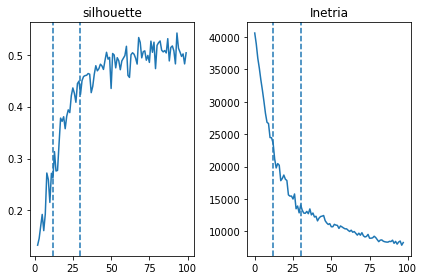

In [237]:
fig, axes = plt.subplots(1,2)
axes[0].plot(scores_array[:,0], scores_array[:,1])
axes[0].axvline(x=12, linestyle = '--')
axes[0].axvline(x=30, linestyle = '--')
axes[0].set_title("silhouette")
axes[1].plot(np.array(Lcost))
axes[1].axvline(x=12, linestyle = '--')
axes[1].axvline(x=30, linestyle = '--')
axes[1].set_title("Inetria")
plt.tight_layout()

n = 30 will be used in the following

#### PCA

In [215]:
from pyspark.ml.feature import PCA

In [238]:
pca = PCA(k=20, inputCol="scaledFeatures", outputCol="pca_features")
pca_model = pca.fit(scaled_data)

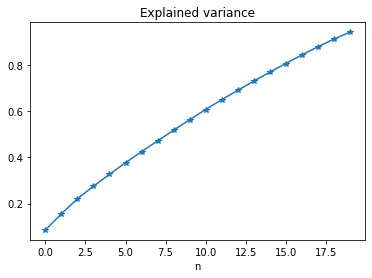

In [239]:
plt.plot(np.cumsum(pca_model.explainedVariance.toArray()), "*-")
plt.title("Explained variance")
plt.xlabel("n")
plt.show()

Unfortunately, there are no selected axes

Let's try the elbow method

In [240]:
pca_cost = []
for k in range(2, 100):
    kmeans_pca = KMeans(featuresCol="pca_features", k=k, predictionCol="pca_cluster").fit(pca_model.transform(scaled_data))
    pca_cost = pca_cost + [kmeans_pca.summary.trainingCost]

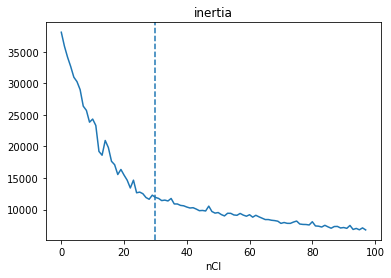

In [244]:
plt.plot(pca_cost)
plt.title("inertia")
plt.xlabel("nCl")
plt.axvline(x=30, linestyle = "--")
plt.show()

No use in PCA transformation?

## Visualization 

In [46]:
kmeans_algo = KMeans(featuresCol="scaledFeatures", k=30)
kmeans_fit = kmeans_algo.fit(scaled_data)


In [49]:
result = kmeans_fit.summary.predictions
result.groupby("prediction").count().sort(desc("count"))

/usr/local/spark/python/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


prediction,count
0,239
16,112
10,105
11,99
18,99
7,94
9,90
12,88
4,86
3,84


Clusters 0, 16, 10, 11 are most popular. Let is try to find difference between them

In [56]:
small_results = result.filter( 
    (small_results["prediction"]==0) | 
    (small_results["prediction"]==16) | 
    (small_results["prediction"]==10) |
    (small_results["prediction"]==11)
)
small_results.count()

555

In [59]:
import plotnine as p9

In [72]:
small_results.filter("prediction == 0").count()

239

In [82]:
import pandas as pd

In [119]:
sum_df = pd.DataFrame()

clusters = result.select("prediction").distinct().toPandas()["prediction"].tolist()
for cluster in clusters:
    sum_ = result.filter("prediction == "+ str(cluster)).select(cols).describe()
    sum_df_ = sum_.filter( (sum_["summary"] == "mean") | (sum_["summary"] == "stddev")).toPandas()
    sum_df_["cluster"] = cluster
    sum_df_["count"] = result.filter("prediction == "+ str(cluster)).count()
    sum_df = pd.concat([sum_df, sum_df_])

In [127]:
sum_df.query("(summary == 'mean')").sort_values("count", ascending=False).head(8).round(decimals=2)

,summary,CERN_LHC_Coll,GeV,None,anomaly,background,citation_count,dark_matter,dark_matter__mass,effective_field_theory,...,number_of_pages,numerical_calculations,p_p__scattering,quantum_chromodynamics,quark,sensitivity,stability,structure,cluster,count
0,mean,0.3389121338912134,0.0,0.0,0.0,0.0,2.1046025104602513,0.0,0.0,0.0,...,18.14644351464435,0.0,0.0,0.0,0.16317991631799164,0.0,0.0,0.0,0,239
0,mean,0.0,0.0,0.0,0.0,0.0,2.857142857142857,0.0,0.0,0.0,...,20.446428571428573,0.07142857142857142,0.0,0.008928571428571428,0.08035714285714286,0.0,0.0,1.0,16,112
0,mean,0.09523809523809523,0.0,0.0,0.0,0.0,2.914285714285714,0.0,0.0,1.0,...,26.4,0.0,0.0,0.05714285714285714,0.02857142857142857,0.0761904761904762,0.0,0.0761904761904762,10,105
0,mean,0.09090909090909091,0.0,0.0,0.0,0.0,1.8080808080808082,0.0,0.0,0.0,...,15.575757575757576,0.030303030303030304,0.0,1.0,0.0707070707070707,0.0,0.0,0.010101010101010102,11,99
0,mean,0.030303030303030304,0.050505050505050504,0.0,0.0,0.0,1.404040404040404,0.0,0.0,0.050505050505050504,...,18.363636363636363,0.04040404040404041,0.0,0.1919191919191919,0.13131313131313133,0.0,0.010101010101010102,0.04040404040404041,18,99
0,mean,0.0,0.06382978723404255,0.0,0.010638297872340425,0.031914893617021274,3.117021276595745,0.0,1.0,0.031914893617021274,...,18.01063829787234,0.1276595744680851,0.0,0.031914893617021274,0.0,0.19148936170212766,0.05319148936170213,0.09574468085106383,7,94
0,mean,0.044444444444444446,0.1111111111111111,0.0,1.0,0.07777777777777778,3.611111111111111,0.011111111111111112,0.03333333333333333,0.022222222222222223,...,22.68888888888889,0.022222222222222223,0.0,0.06666666666666667,0.06666666666666667,0.08888888888888889,0.022222222222222223,0.05555555555555555,9,90
0,mean,0.03409090909090909,0.0,0.0,0.0,0.0,2.477272727272727,0.0,0.0,0.0,...,21.40909090909091,1.0,0.0,0.0,0.022727272727272728,0.0,0.0,0.0,12,88


In [139]:
dfResult = small_results.toPandas()
df = pd.DataFrame()

/usr/local/spark/python/pyspark/sql/pandas/conversion.py:87: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  Unsupported type in conversion to Arrow: VectorUDT
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.


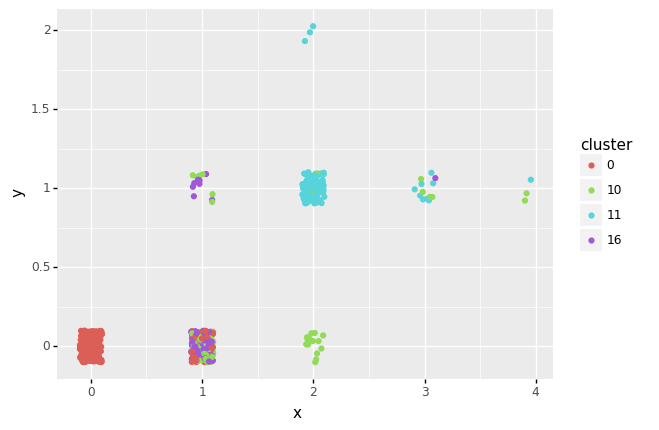

<ggplot: (8731539237849)>

In [249]:
df["cluster"] = dfResult.prediction.astype("category")
df["x"] = dfResult.CERN_LHC_Coll + 2*dfResult.quantum_chromodynamics + dfResult.structure + dfResult.effective_field_theory
df["y"] = dfResult.numerical_calculations + dfResult.quantum_chromodynamics + dfResult.sensitivity
(
 p9.ggplot(df) + p9.aes(x="x", y="y", color = "cluster") +
    p9.geom_jitter(position = p9.position_jitter(width = 0.1, height=0.1))
)

In [143]:
dfResult.columns

Index(['CERN_LHC_Coll', 'GeV', 'None', 'anomaly', 'background',
       'citation_count', 'dark_matter', 'dark_matter__mass',
       'effective_field_theory', 'heavy_ion__scattering', 'higher-order__1',
       'kinematics', 'lattice', 'lattice_field_theory', 'new_physics',
       'num_refs', 'number_of_pages', 'numerical_calculations',
       'p_p__scattering', 'quantum_chromodynamics', 'quark', 'sensitivity',
       'stability', 'structure', 'title', 'id', 'features', 'scaledFeatures',
       'prediction'],
      dtype='object')

In [131]:
sum_df.query("summary == 'mean'").sort_values("CERN_LHC_Coll", ascending=False)

,summary,CERN_LHC_Coll,GeV,None,anomaly,background,citation_count,dark_matter,dark_matter__mass,effective_field_theory,...,number_of_pages,numerical_calculations,p_p__scattering,quantum_chromodynamics,quark,sensitivity,stability,structure,cluster,count
0,mean,1.0,0.0,0.0,0.021739130434782608,0.043478260869565216,0.5652173913043478,0.0,0.0,0.043478260869565216,...,13.91304347826087,0.043478260869565216,1.0,0.021739130434782608,0.0,0.021739130434782608,0.0,0.0,27,46
0,mean,0.8125,0.0,0.0,0.03125,0.03125,2.125,0.0,0.0,0.03125,...,13.375,0.03125,0.40625,0.03125,0.0,0.03125,0.0,0.0,29,32
0,mean,0.6470588235294118,0.0,0.0,0.0,0.0,1.8823529411764706,0.0,0.0,0.058823529411764705,...,32.76470588235294,0.11764705882352941,1.0,0.23529411764705882,0.0,0.058823529411764705,0.058823529411764705,0.0,17,17
0,mean,0.4166666666666667,0.0,0.0,0.0,0.0,2.25,0.0,0.0,0.0,...,29.333333333333332,0.16666666666666666,0.0,0.16666666666666666,0.0,0.0,0.08333333333333333,0.0,20,12
0,mean,0.3389121338912134,0.0,0.0,0.0,0.0,2.1046025104602513,0.0,0.0,0.0,...,18.14644351464435,0.0,0.0,0.0,0.16317991631799164,0.0,0.0,0.0,0,239
0,mean,0.3333333333333333,0.0,0.0,0.0,0.0,57.0,0.0,0.0,0.0,...,209.33333333333334,0.0,0.0,0.3333333333333333,0.0,0.0,0.3333333333333333,0.0,24,3
0,mean,0.2857142857142857,0.0,0.0,0.02857142857142857,0.0,0.11428571428571428,0.11428571428571428,0.0,0.2571428571428571,...,218.37142857142857,0.08571428571428572,0.02857142857142857,0.2571428571428571,0.08571428571428572,0.05714285714285714,0.0,0.11428571428571428,25,35
0,mean,0.23880597014925373,0.04477611940298507,0.0,0.0,0.014925373134328358,2.208955223880597,0.0,0.0,0.05970149253731343,...,21.64179104477612,0.14925373134328357,0.0,0.16417910447761194,0.029850746268656716,0.0,0.08955223880597014,0.014925373134328358,22,67
0,mean,0.2,0.2,0.0,0.2,0.0,6.6,0.2,0.0,0.0,...,195.6,0.2,0.2,0.0,0.0,0.2,0.0,0.2,5,5
0,mean,0.15584415584415584,0.05194805194805195,0.0,0.0,0.0,1.8181818181818181,0.0,0.0,0.0,...,23.571428571428573,0.1038961038961039,0.0,0.1038961038961039,0.012987012987012988,0.07792207792207792,0.03896103896103896,0.05194805194805195,1,77


### Stability

In [188]:
def clusters_to_dict(preds = None, seed = 1, k = 37, data = scaled_data):
    """
    clusters data using KMeans alorith with specified seed and number of clusters 
    and returns result as a dictionary id:cluster
    """
    if not preds:
        preds = KMeans(featuresCol="scaledFeatures", k=k, seed=seed).\
            fit(data).\
            transform(scaled_data).select("id", "prediction")
    pred_dict = dict()
    for k_ in range(k):
        cl_dict = {p[0]:k_ for p in preds.filter("prediction == "+str(k_)).select("id").collect()}
        pred_dict = pred_dict | cl_dict
    return pred_dict

In [205]:
def cluster_conjugation_matrix(cluster_dict, n = None):
    """
    returns conjugations matrix from the clustr dict
    """
    if not n:
       n=len( cluster_dict.keys())
    keys = cluster_dict.keys()
    return np.array(
        [[1 if cluster_dict[i1] == cluster_dict[i2] else 0 for i1 in keys] for i2 in keys]
    )

In [230]:
R1 = clusters_to_dict(seed = 4, k=100)
R2 = clusters_to_dict(seed = 10, k=100)

M1 = cluster_conjugation_matrix(R1)
M2 = cluster_conjugation_matrix(R2)

np.sum(np.abs(M1 - M2))/M1.size

0.09436300229979626